# FEM Application
After developing the theory for a Finite Element Method in *Theory_FEM.ipynb*, we present a small implementation of what such a simulation might look like.



In [20]:
# Import the necessary libraries
from fem import *
import numpy as np
import matplotlib.pyplot as plt


# Control variables
# These are the variables that control our simulation.
bounds  = [(0,1),(0,1)]         # Domain bounds
h       = 2e-2                  # Mesh Fineness parameter
FF      = lambda r,z: abs(r)    # Discretisation function
dt      = 5e-2                  # Simulation time step  

# Define a Source function
f       = lambda r,z,t: np.exp(-((z-v*t-o)**2 + r**2)/s)
v       = 1                     # Source wave speed
s       = 1e-2                  # Source std
o       = 2e-1                  # Source offset

# Now we will get the mesh and points
points,mesh = get_mesh(h,FF,bounds)
boundary    = get_boundary(points)

# Buld T, S matrices
T,S = get_TS(points,mesh)

# Construct the scheme matrix and apply boundary conditions
Ap= get_scheme_matrix(dt,T,S)
A = set_bc_lhs(boundary,Ap,points,mesh)

# Define the initial condition vectors
# Goal is to solve for U_next, using U_curr and U_prev
U_curr = np.zeros(len(points))
U_prev = np.zeros(len(points))
F      = np.array([f(*point,0) for point in points])

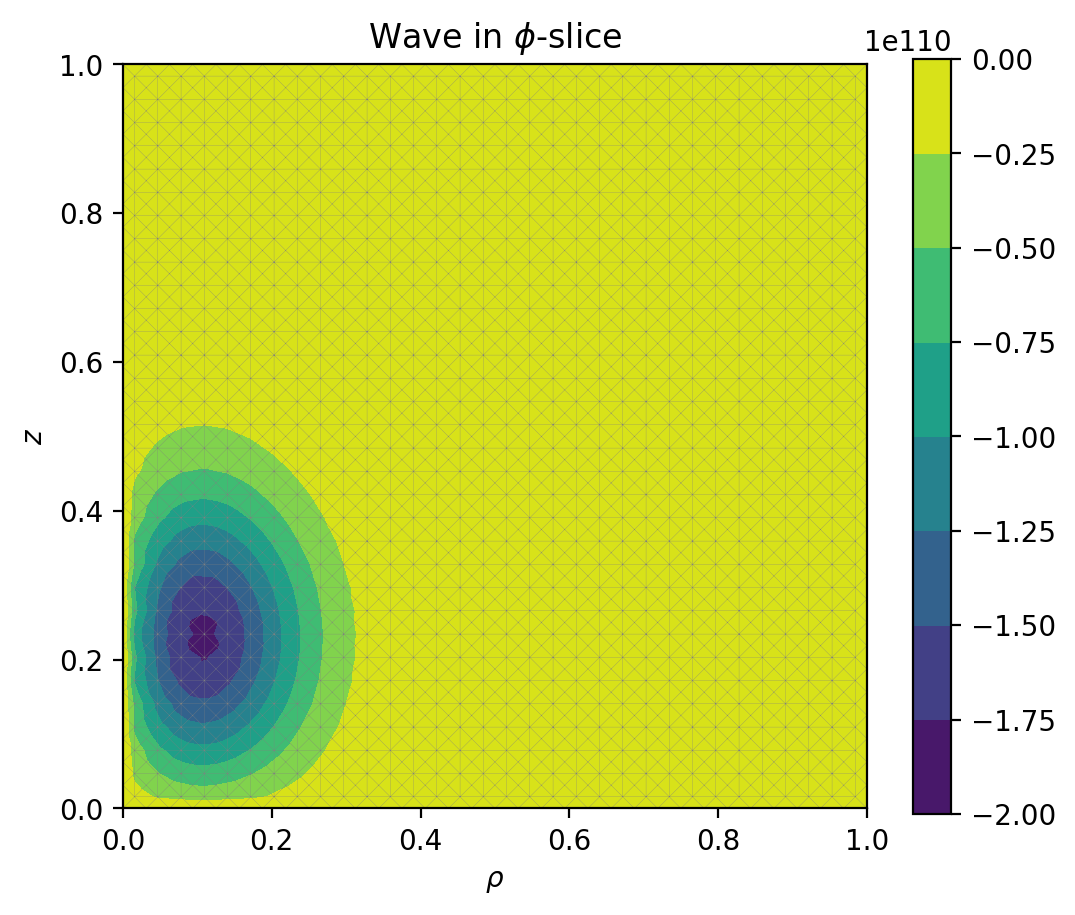

In [22]:
# Let's take one step in time and plot
# U = step(dt,A,S,T,U_curr,U_prev,F)

# U = run(0.006,dt,A,S,T,U_curr,U_prev,f,points);

t = 200*dt
# Get the number of iterations
N = int(t//dt)
Ff = []
# Display a progress bar for fun
for i in range(N):
    Ff = get_F(f,i*dt,points)
    U_curr, U_prev = step(dt,A,S,T,U_curr,U_prev,Ff)

plot_U(points,mesh,U_curr)

In [11]:
def g(x):
    return x**2

def f(x):
    for i in range(2):
        x = g(x)
    
    return x

x =np.array([1,2]) 
x=f(x)
x

array([ 1, 16])

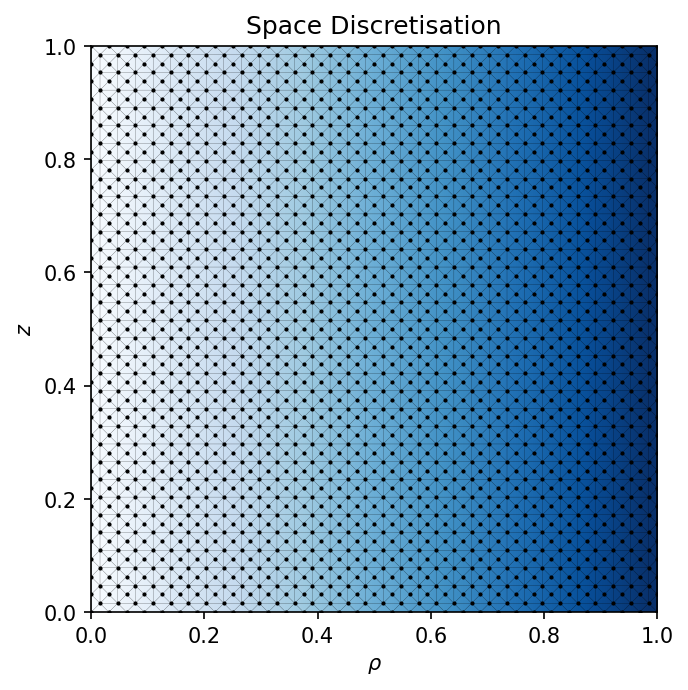

In [12]:
# Now let's print some stuff before we start solving.A
# Firstly the mesh.
plot_mesh(points,mesh,FF);

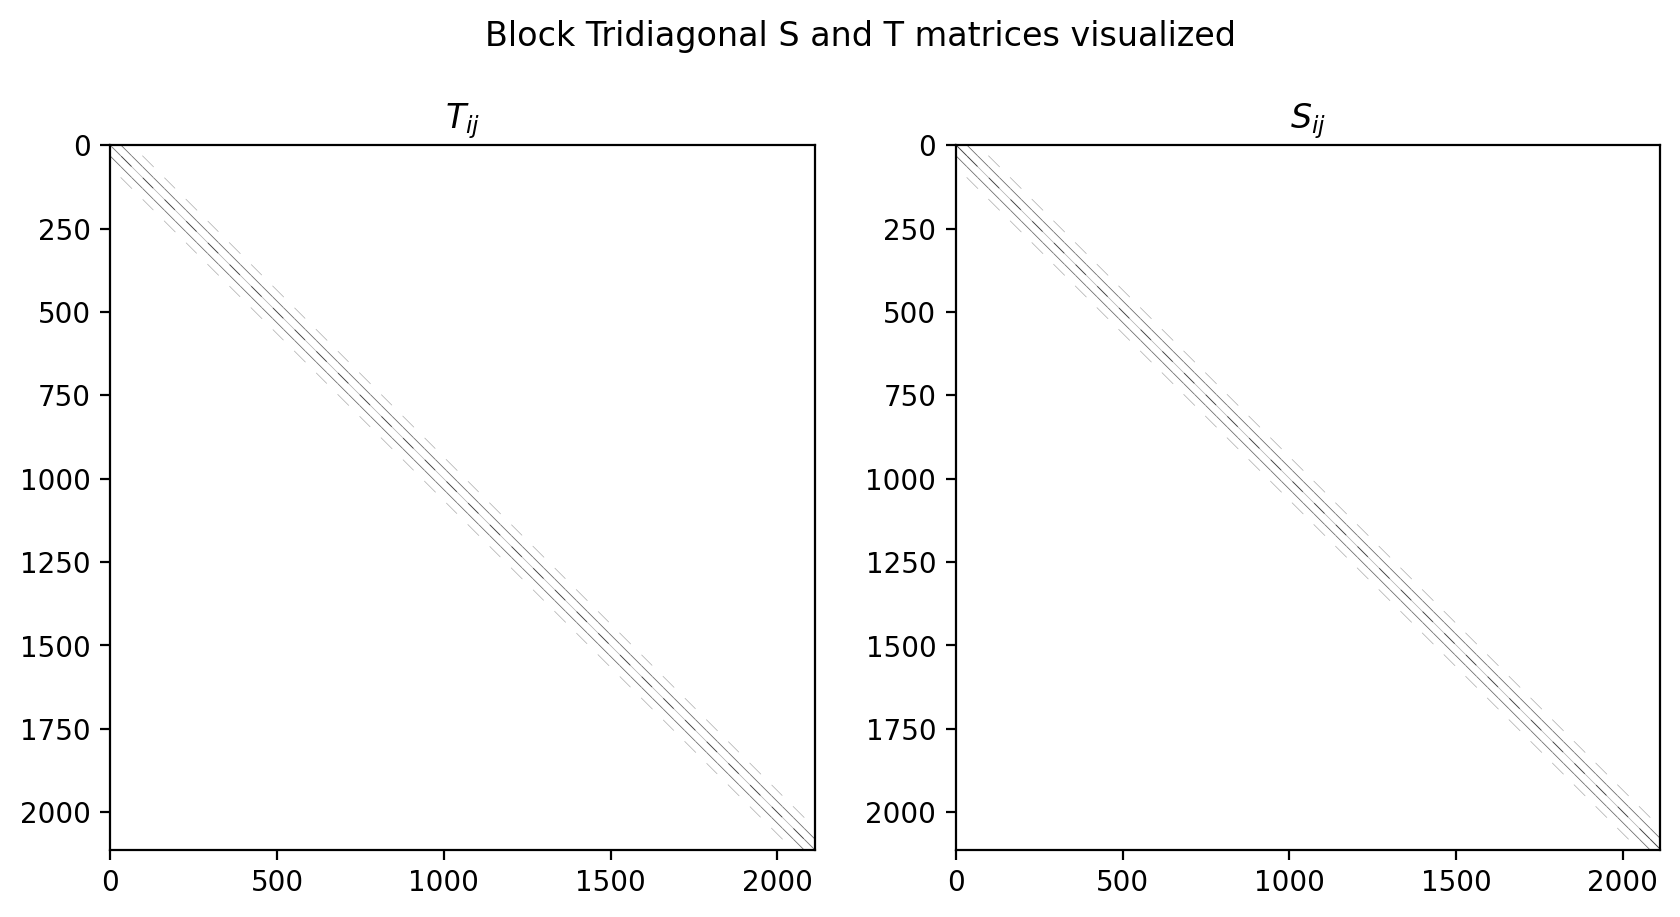

In [13]:
# Now let's plto the T,S Matrices
plot_TS(T,S);

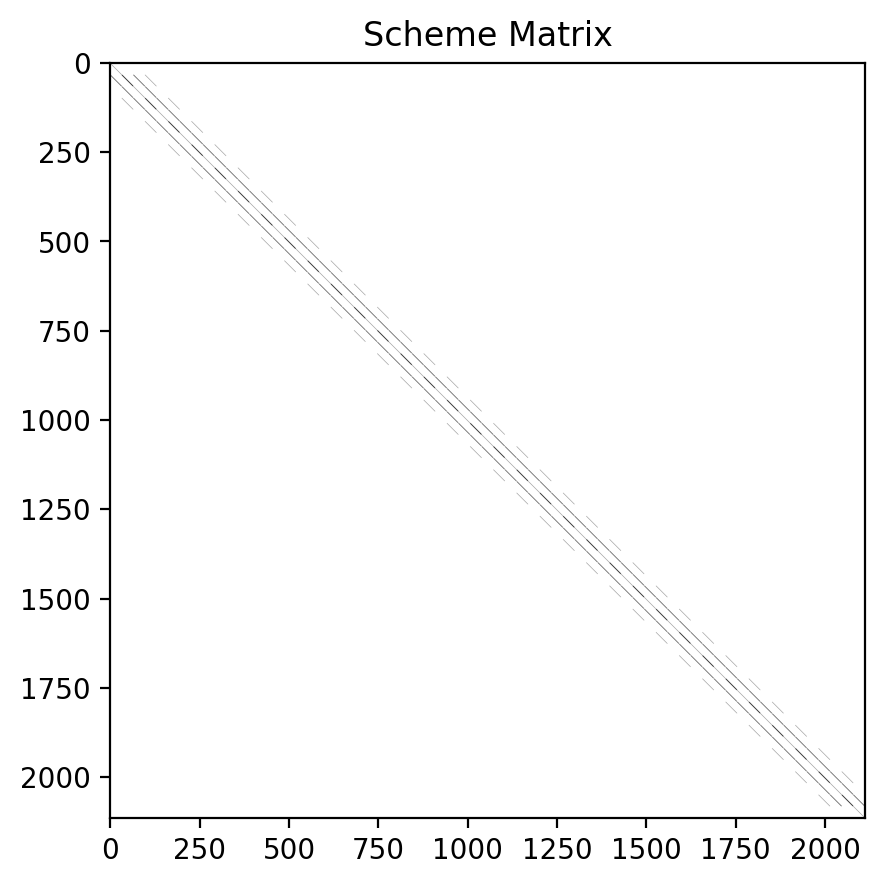

In [14]:
# Plotting the A matrix
plot_A(Ap);